In [39]:
import sys

print(sys.version_info)

sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)


In [40]:
import tensorflow as tf

print(tf.__version__)

2.12.0


In [41]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [42]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [43]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

In [44]:
tf.keras.utils.get_file("ridership.tgz", "https://github.com/ageron/data/raw/main/ridership.tgz", cache_dir=".", extract=True)

'./datasets/ridership.tgz'

In [45]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])

In [46]:
df.dtypes

service_date      datetime64[ns]
day_type                  object
bus                        int64
rail_boardings             int64
total_rides                int64
dtype: object

In [47]:
df.columns = ['day', 'day_type', 'bus', 'rail', 'total']
df.dtypes

day         datetime64[ns]
day_type            object
bus                  int64
rail                 int64
total                int64
dtype: object

In [48]:
df = df.drop('total', axis=1)
df = df.drop_duplicates()
df = df.sort_values('day').set_index('day')

In [49]:
df.dtypes

day_type    object
bus          int64
rail         int64
dtype: object

In [50]:
df['day_type'].value_counts()

W    5336
U    1216
A    1087
Name: day_type, dtype: int64

In [51]:
df.head()

,day_type,bus,rail
day,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


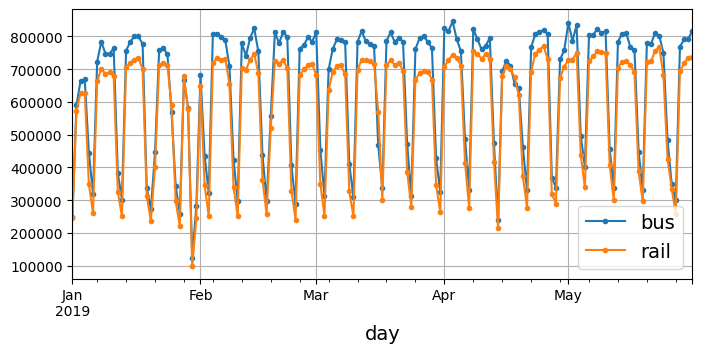

In [52]:
df['2019-01':'2019-05'].plot(grid=True, marker='.', figsize=(8, 3.5))
plt.show()

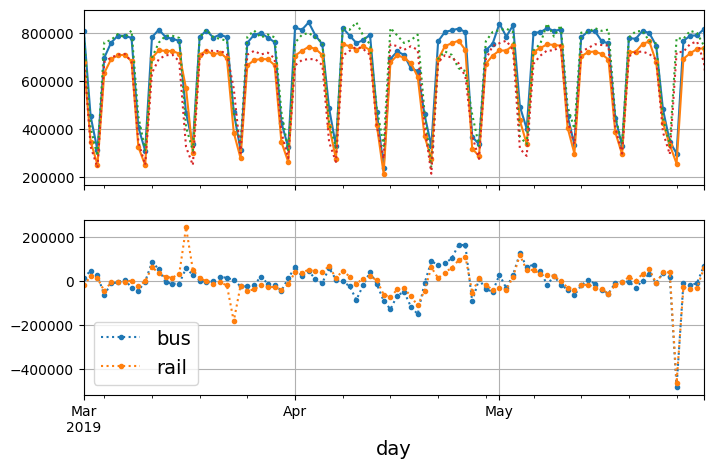

In [53]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".", linestyle=':')  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
#save_fig("differencing_plot")  # extra code – saves the figure for the book
plt.show()

In [54]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

In [55]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [56]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

In [57]:
df.head()

,day_type,bus,rail
day,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


In [58]:
df['day_type'].value_counts()

W    5336
U    1216
A    1087
Name: day_type, dtype: int64

In [59]:
period = slice("2001", "2019")
df_monthly = df.resample('M').mean()

<ipython-input-59-a2eb04972c22>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly = df.resample('M').mean()


In [60]:
df_monthly.head(15)

,bus,rail
day,,
2001-01-31,807190.580645,474591.419355
2001-02-28,848889.000000,488188.178571
2001-03-31,865392.419355,498825.096774
2001-04-30,835126.366667,490444.533333
2001-05-31,862701.419355,507862.258065
2001-06-30,833149.033333,519549.900000
2001-07-31,791519.258065,516928.967742
2001-08-31,795070.580645,516604.387097
2001-09-30,830298.400000,491522.833333


In [61]:
type(period)

slice

In [62]:
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

In [63]:
rolling_average_12_months.head(20)

,bus,rail
day,,
2001-01-31,NaN,NaN
2001-02-28,NaN,NaN
2001-03-31,NaN,NaN
2001-04-30,NaN,NaN
2001-05-31,NaN,NaN
2001-06-30,NaN,NaN
2001-07-31,NaN,NaN
2001-08-31,NaN,NaN
2001-09-30,NaN,NaN


In [64]:
rolling_average_12_months.tail(20)

,bus,rail
day,,
2018-05-31,674525.941353,624398.363287
2018-06-30,671394.258020,621531.957732
2018-07-31,671319.180063,621547.809882
2018-08-31,669610.021461,620598.153968
2018-09-30,666215.704794,619426.376190
2018-10-31,666736.078450,620706.991782
2018-11-30,664188.734005,619575.158449
2018-12-31,663575.271640,618822.268664
2019-01-31,658900.561962,615358.505223


In [65]:
df_monthly.tail(20)

,bus,rail
day,,
2020-04-30,195055.066667,75553.666667
2020-05-31,220091.903226,72099.290323
2020-06-30,244389.700000,98504.500000
2020-07-31,277691.193548,137260.032258
2020-08-31,275514.032258,137437.354839
2020-09-30,286440.466667,151890.633333
2020-10-31,286671.096774,153237.000000
2020-11-30,249798.066667,127163.466667
2020-12-31,240878.967742,118744.290323


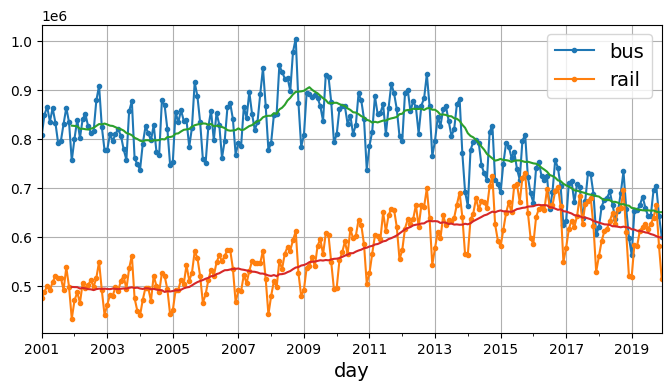

In [66]:
fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
#save_fig("long_term_ridership_plot")  # extra code – saves the figure for the book
plt.show()

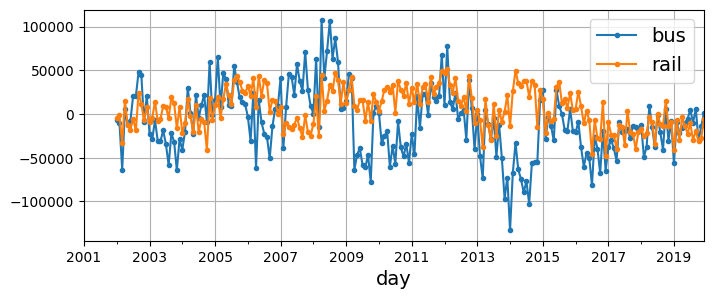

In [67]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
#save_fig("yearly_diff_plot")  # extra code – saves the figure for the book
plt.show()

In [68]:
if "google.colab" in sys.modules:
    %pip install -q -U statsmodels

In [69]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")

In [70]:
rail_series.head()

day
2019-01-01    245852
2019-01-02    573542
2019-01-03    627781
2019-01-04    628514
2019-01-05    348257
Freq: D, Name: rail, dtype: int64

In [71]:
rail_series.tail()

day
2019-05-27    256757
2019-05-28    694292
2019-05-29    717681
2019-05-30    735508
2019-05-31    738322
Freq: D, Name: rail, dtype: int64

In [72]:
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()

In [73]:
y_pred = model.forecast(5)

In [74]:
y_pred

2019-06-01    427758.626288
2019-06-02    323574.505107
2019-06-03    566686.087059
2019-06-04    720952.969705
2019-06-05    737304.722793
Freq: D, Name: predicted_mean, dtype: float64

In [75]:
df["rail"].loc["2019-05-25"]

426932

In [76]:
df["rail"].loc["2019-06-01"]

379044

In [77]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)

In [78]:
time_period

DatetimeIndex(['2019-03-01', '2019-03-02', '2019-03-03', '2019-03-04',
               '2019-03-05', '2019-03-06', '2019-03-07', '2019-03-08',
               '2019-03-09', '2019-03-10', '2019-03-11', '2019-03-12',
               '2019-03-13', '2019-03-14', '2019-03-15', '2019-03-16',
               '2019-03-17', '2019-03-18', '2019-03-19', '2019-03-20',
               '2019-03-21', '2019-03-22', '2019-03-23', '2019-03-24',
               '2019-03-25', '2019-03-26', '2019-03-27', '2019-03-28',
               '2019-03-29', '2019-03-30', '2019-03-31', '2019-04-01',
               '2019-04-02', '2019-04-03', '2019-04-04', '2019-04-05',
               '2019-04-06', '2019-04-07', '2019-04-08', '2019-04-09',
               '2019-04-10', '2019-04-11', '2019-04-12', '2019-04-13',
               '2019-04-14', '2019-04-15', '2019-04-16', '2019-04-17',
               '2019-04-18', '2019-04-19', '2019-04-20', '2019-04-21',
               '2019-04-22', '2019-04-23', '2019-04-24', '2019-04-25',
      

In [79]:
time_period.shift(-1)

DatetimeIndex(['2019-02-28', '2019-03-01', '2019-03-02', '2019-03-03',
               '2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07',
               '2019-03-08', '2019-03-09', '2019-03-10', '2019-03-11',
               '2019-03-12', '2019-03-13', '2019-03-14', '2019-03-15',
               '2019-03-16', '2019-03-17', '2019-03-18', '2019-03-19',
               '2019-03-20', '2019-03-21', '2019-03-22', '2019-03-23',
               '2019-03-24', '2019-03-25', '2019-03-26', '2019-03-27',
               '2019-03-28', '2019-03-29', '2019-03-30', '2019-03-31',
               '2019-04-01', '2019-04-02', '2019-04-03', '2019-04-04',
               '2019-04-05', '2019-04-06', '2019-04-07', '2019-04-08',
               '2019-04-09', '2019-04-10', '2019-04-11', '2019-04-12',
               '2019-04-13', '2019-04-14', '2019-04-15', '2019-04-16',
               '2019-04-17', '2019-04-18', '2019-04-19', '2019-04-20',
               '2019-04-21', '2019-04-22', '2019-04-23', '2019-04-24',
      

In [80]:
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7

In [81]:
mae

32040.7201012105

In [83]:
y_preds.head()

2019-03-01    696955.515289
2019-03-02    342139.361035
2019-03-03    253320.415572
2019-03-04    633245.753031
2019-03-05    696723.448693
Freq: D, dtype: float64

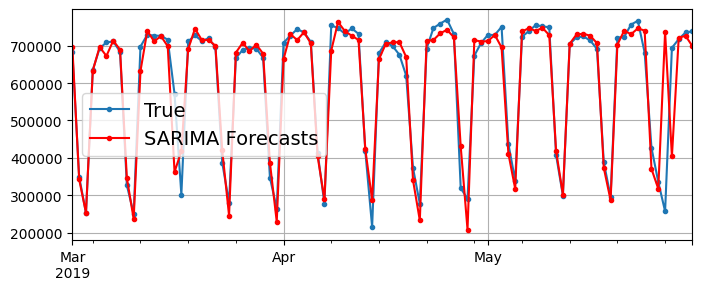

In [84]:
# extra code – displays the SARIMA forecasts
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

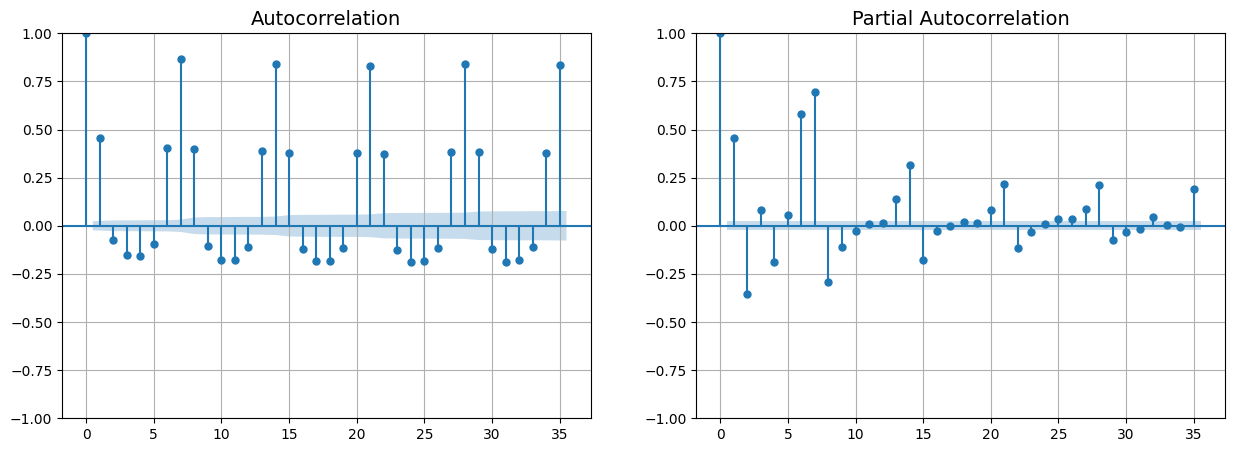

In [85]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

In [86]:
df.dtypes

day_type    object
bus          int64
rail         int64
dtype: object

In [87]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [88]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [89]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [90]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [91]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

Before we continue looking at the data, let's split the time series into three periods, for training, validation and testing. We won't look at the test data for now:

In [92]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [93]:
rail_train.head(10)

day
2016-01-01    0.319835
2016-01-02    0.365509
2016-01-03    0.287661
2016-01-04    0.703185
2016-01-05    0.727716
2016-01-06    0.733167
2016-01-07    0.736809
2016-01-08    0.732495
2016-01-09    0.391597
2016-01-10    0.263073
Name: rail, dtype: float64

In [94]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [101]:
count = 0
for i in list(train_ds):
  print(i)
  count += 1
  if count == 2:
    break

(<tf.Tensor: shape=(32, 56), dtype=float64, numpy=
array([[0.303129, 0.766595, 0.769441, ..., 0.818665, 0.814758, 0.484312],
       [0.722634, 0.699928, 0.389468, ..., 0.686671, 0.728488, 0.733303],
       [0.424387, 0.291688, 0.702745, ..., 0.7505  , 0.736551, 0.690415],
       ...,
       [0.490822, 0.537443, 0.532909, ..., 0.447059, 0.328391, 0.557822],
       [0.292995, 0.724012, 0.748201, ..., 0.775776, 0.726694, 0.396705],
       [0.419604, 0.710906, 0.71368 , ..., 0.712092, 0.394014, 0.286948]])>, <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([0.357946, 0.743467, 0.370873, 0.751259, 0.745511, 0.735681,
       0.778823, 0.787408, 0.748046, 0.775495, 0.731858, 0.743427,
       0.712596, 0.808415, 0.782134, 0.739158, 0.738941, 0.725091,
       0.710058, 0.747181, 0.796878, 0.741459, 0.490054, 0.395977,
       0.474411, 0.343853, 0.780569, 0.786422, 0.33493 , 0.741773,
       0.350024, 0.71522 ])>)
(<tf.Tensor: shape=(32, 56), dtype=float64, numpy=
array([[0.253184, 0.60702 ,

In [102]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 9s 21ms/step - loss: 0.1618 - mae: 0.4550 - val_loss: 0.0101 - val_mae: 0.1072
Epoch 2/500
33/33 [==============================] - 1s 13ms/step - loss: 0.0138 - mae: 0.1264 - val_loss: 0.0065 - val_mae: 0.0859
Epoch 3/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0091 - mae: 0.1002 - val_loss: 0.0059 - val_mae: 0.0819
Epoch 4/500
33/33 [==============================] - 1s 15ms/step - loss: 0.0073 - mae: 0.0878 - val_loss: 0.0049 - val_mae: 0.0736
Epoch 5/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0073 - mae: 0.0890 - val_loss: 0.0048 - val_mae: 0.0710
Epoch 6/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0076 - mae: 0.0937 - val_loss: 0.0075 - val_mae: 0.0957
Epoch 7/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0073 - mae: 0.0909 - val_loss: 0.0042 - val_mae: 0.0665
Epoch 8/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0059